#Transfer Learning for Image Classification

## Step 1: Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load and Preprocess Data

In [2]:
# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [5]:
#i have to shuffle batch and prefetch the dataset to avoide memory problems
img_size = 96
batch_size = 32

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
train_ds = train_ds.map(
    lambda x, y: (preprocess_input(tf.image.resize(tf.cast(x, tf.float32), (img_size, img_size))), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
test_ds = test_ds.map(
    lambda x, y: (preprocess_input(tf.image.resize(tf.cast(x, tf.float32), (img_size, img_size))), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Step 3: Load the Pre-trained Model

In [6]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(96, 96, 3)
)

base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 4: Add a Custom Classifier on Top

In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

##Step 5: Compile the Model

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##Step 6: Train the Model

In [10]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 113s 52ms/step - accuracy: 0.7626 - loss: 0.7110 - val_accuracy: 0.8682 - val_loss: 0.3827
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8506 - loss: 0.4373 - val_accuracy: 0.8763 - val_loss: 0.3612
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8606 - loss: 0.4026 - val_accuracy: 0.8759 - val_loss: 0.3598
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8651 - loss: 0.3845 - val_accuracy: 0.8787 - val_loss: 0.3629
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8778 - loss: 0.3573 - val_accuracy: 0.8828 - val_loss: 0.3506
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8817 - loss: 0.3424 - val_accuracy: 0.8806 - val_loss: 0.3614
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8867 - loss: 0.3215 - val_accuracy: 0.8827 - val_loss: 0.3553
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.8916 

## Step 7: Evaluate the model

**Accuracy**

In [11]:
test_loss, test_acc = model.evaluate(
    test_ds)

print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8865 - loss: 0.3593
Test Accuracy: 0.8853


In [12]:
import numpy as np

# Predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step


In [13]:
from sklearn.metrics import classification_report

# Convert y_test from (N, 1) → (N,)
y_test_flat = y_test.squeeze()

report = classification_report(
    y_test_flat,
    y_pred,
    target_names=class_names
)

print(report)

              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.91      0.92      0.92      1000
        bird       0.91      0.83      0.87      1000
         cat       0.77      0.85      0.80      1000
        deer       0.85      0.86      0.86      1000
         dog       0.88      0.82      0.85      1000
        frog       0.90      0.92      0.91      1000
       horse       0.91      0.91      0.91      1000
        ship       0.93      0.93      0.93      1000
       truck       0.92      0.91      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



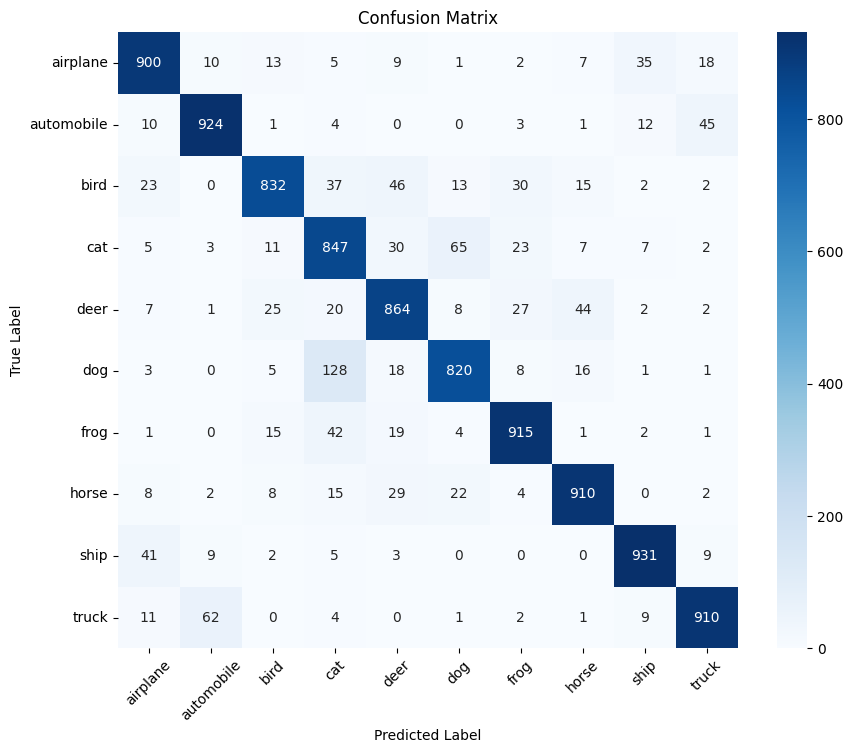

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Flatten y_test to 1D
y_test_flat = y_test.squeeze()

# Compute confusion matrix
cm = confusion_matrix(y_test_flat, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## unfreeze the last few layers of DenseNet and fine-tune it

In [15]:
from tensorflow.keras import optimizers


In [16]:
# Make the base model trainable
base_model.trainable = True

# Freeze all layers except the last N (e.g., last 20)
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [22]:


# Compile with smaller learning rate
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 58ms/step - accuracy: 0.9240 - loss: 0.2100 - val_accuracy: 0.8923 - val_loss: 0.3583
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9252 - loss: 0.2107 - val_accuracy: 0.8925 - val_loss: 0.3571
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9231 - loss: 0.2114 - val_accuracy: 0.8929 - val_loss: 0.3571
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9264 - loss: 0.2055 - val_accuracy: 0.8928 - val_loss: 0.3561
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9263 - loss: 0.2033 - val_accuracy: 0.8927 - val_loss: 0.3560
